In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np

# local imports
import gpvisc

# deep learning libraries
import torch

# CPU or GPU?
device = gpvisc.get_device()
device

Will run on cuda


'cuda'

# First step : import data and model

In [2]:
def prepare_data(ds):
    """Prepare training, validation, and test datasets."""
    X_train = torch.FloatTensor(np.concatenate((1000/ds.T_train, ds.P_train/30.0, ds.X_train[:,0:12]), axis=1).copy())
    X_valid = torch.FloatTensor(np.concatenate((1000/ds.T_valid, ds.P_valid/30.0, ds.X_valid[:,0:12]), axis=1).copy())
    X_test = torch.FloatTensor(np.concatenate((1000/ds.T_test, ds.P_test/30.0, ds.X_test[:,0:12]), axis=1).copy())

    Y_train = torch.FloatTensor(ds.y_train.ravel().copy()) / gpvisc.Y_scale()
    Y_valid = torch.FloatTensor(ds.y_valid.ravel().copy()) / gpvisc.Y_scale()
    Y_test = torch.FloatTensor(ds.y_test.ravel().copy()) / gpvisc.Y_scale()

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

# Data loading
print("Loading the viscosity datasets...")
ds = gpvisc.data_loader()

# We prepare them as done for the GP model
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = prepare_data(ds)

# load the model
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)

# make predictions using the greybox ANN model
greybox_train_preds = gpvisc.predict(X_train, gp_model, likelihood, model_to_use="ann")
greybox_valid_preds = gpvisc.predict(X_valid, gp_model, likelihood, model_to_use="ann")
greybox_test_preds = gpvisc.predict(X_test, gp_model, likelihood, model_to_use="ann")

# for the GP we glue things together as done during final training
X_train_valid = torch.cat((X_train, X_valid)).clone()
Y_train_valid = torch.cat((Y_train, Y_valid)).clone().ravel()

# make predictions using the GP, which will refine the greybox ANN predictions
GP_preds_train_valid, _ = gpvisc.predict(X_train_valid, gp_model, likelihood)
GP_preds_test, _ = gpvisc.predict(X_test, gp_model, likelihood)

# put bakc the Y values in numpy array with the good scale
Y_train = (Y_train*gpvisc.Y_scale()).cpu().detach().numpy()
Y_valid = (Y_valid*gpvisc.Y_scale()).cpu().detach().numpy()
Y_test = (Y_test*gpvisc.Y_scale()).cpu().detach().numpy()
Y_train_valid = (Y_train_valid*gpvisc.Y_scale()).cpu().detach().numpy()

Loading the viscosity datasets...


/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


# Print metrics

We print the root mean square error, the median absolute error and the R2 score for the different datasets used to train the greybox artifical neural network (ANN) and the Gaussian process (GP) models.

In [4]:
from sklearn.metrics import root_mean_squared_error, median_absolute_error, r2_score

print("RMSE of the greybox ANN:")
print("Train: {:.2f}".format(root_mean_squared_error(Y_train,greybox_train_preds)))
print("Valid: {:.2f}".format(root_mean_squared_error(Y_valid,greybox_valid_preds)))
print("Test: {:.2f}".format(root_mean_squared_error(Y_test,greybox_test_preds)))

mse_test_ourdatabase = root_mean_squared_error(Y_test[ds.Sciglass_test.ravel() == False], 
                                               greybox_test_preds[ds.Sciglass_test.ravel() == False])

print("Test (our dataset): {:.2f}".format(mse_test_ourdatabase))


print("\nRMSE of the GP model:")
print("Train-Valid: {:.2f}".format(root_mean_squared_error(Y_train_valid,GP_preds_train_valid)))
print("Test: {:.2f}".format(root_mean_squared_error(Y_test,GP_preds_test)))

mse_test_ourdatabase = root_mean_squared_error(Y_test[ds.Sciglass_test.ravel() == False], 
                                               GP_preds_test[ds.Sciglass_test.ravel() == False])

print("Test (our dataset): {:.2f}".format(mse_test_ourdatabase))

print("\nMAE of the greybox ANN:")
print("Train: {:.2f}".format(median_absolute_error(Y_train,greybox_train_preds)))
print("Valid: {:.2f}".format(median_absolute_error(Y_valid,greybox_valid_preds)))
print("Test: {:.2f}".format(median_absolute_error(Y_test,greybox_test_preds)))
mae_test_ourdatabase = median_absolute_error(Y_test[ds.Sciglass_test.ravel() == False], 
                                               greybox_test_preds[ds.Sciglass_test.ravel() == False])
print("Test (our dataset): {:.2f}".format(mae_test_ourdatabase))

print("\nMAE of the GP model:")
print("Train-Valid: {:.2f}".format(median_absolute_error(Y_train_valid,GP_preds_train_valid)))
print("Test: {:.2f}".format(median_absolute_error(Y_test,GP_preds_test)))
mae_test_ourdatabase = median_absolute_error(Y_test[ds.Sciglass_test.ravel() == False], 
                                               GP_preds_test[ds.Sciglass_test.ravel() == False])
print("Test (our dataset): {:.2f}".format(mae_test_ourdatabase))

print("\nR2 of the greybox ANN:")
print("Train: {:.3f}".format(r2_score(Y_train, greybox_train_preds)))
print("Valid: {:.3f}".format(r2_score(Y_valid, greybox_valid_preds)))
print("Test: {:.3f}".format(r2_score(Y_test, greybox_test_preds)))
mae_test_ourdatabase = r2_score(Y_test[ds.Sciglass_test.ravel() == False], 
                                               greybox_test_preds[ds.Sciglass_test.ravel() == False])
print("Test (our dataset): {:.3f}".format(mae_test_ourdatabase))

print("\nR2 of the GP model:")
print("Train-Valid: {:.3f}".format(r2_score(Y_train_valid, GP_preds_train_valid)))
print("Test: {:.3f}".format(r2_score(Y_test, GP_preds_test)))
mae_test_ourdatabase = r2_score(Y_test[ds.Sciglass_test.ravel() == False], 
                                GP_preds_test[ds.Sciglass_test.ravel() == False])
print("Test (our dataset): {:.3f}".format(mae_test_ourdatabase))

RMSE of the greybox ANN:
Train: 0.42
Valid: 0.55
Test: 0.48
Test (our dataset): 0.33

RMSE of the GP model:
Train-Valid: 0.35
Test: 0.44
Test (our dataset): 0.32

MAE of the greybox ANN:
Train: 0.18
Valid: 0.21
Test: 0.19
Test (our dataset): 0.18

MAE of the GP model:
Train-Valid: 0.12
Test: 0.15
Test (our dataset): 0.14

R2 of the greybox ANN:
Train: 0.991
Valid: 0.984
Test: 0.988
Test (our dataset): 0.995

R2 of the GP model:
Train-Valid: 0.994
Test: 0.990
Test (our dataset): 0.996


# Compare the Greybox ANN and the GP models

We compare predictions of the two models as a function of temperature for three different compositions.

We add water in a granite glass for instance:

Converting weight percent composition to mole fraction...
Converting weight percent composition to mole fraction...
Converting weight percent composition to mole fraction...


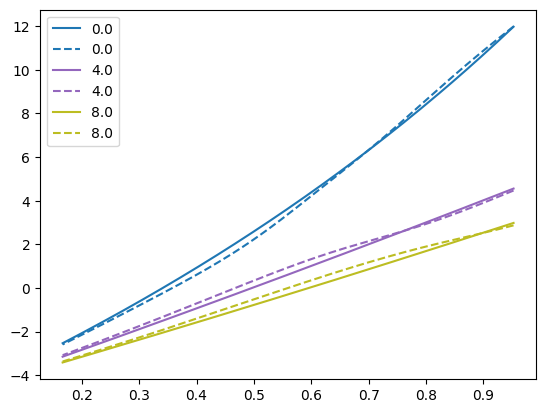

In [5]:
plt.figure()
for h2o_content in [0.0, 4.0, 8.0]:
    # add SiO2 curve
    db_in = gpvisc.generate_query_single(sio2=50.,
                                     tio2=0.0,
                                     al2o3=13.3,
                                     feo=0.9,
                                     mno=0.02,
                                     mgo=0.05,
                                     cao=0.41,
                                     na2o=3.43,
                                     k2o=5.36,
                                     h2o=h2o_content,
                                    composition_mole = False,
                                    T_init = 1050.0, T_final= 6000.0,
                                    P_init = 0.0, P_final = 0.0,
                                    nb_values = 300,
                                    )
    
    # calculate the input for the GP
    X_in = gpvisc.scale_for_gaussianprocess(db_in["T"], db_in["P"], db_in)
    sio2_visco_mean2, visco_std = gpvisc.predict(X_in, gp_model, likelihood)
    sio2_visco_mean = gp_model.mean_f(torch.FloatTensor(X_in)).detach().numpy()*gpvisc.Y_scale()

    plt.plot(1000/db_in["T"], sio2_visco_mean, label=str(h2o_content), color="C"+str(int(h2o_content)))#surface_temperat
    plt.plot(1000/db_in["T"], sio2_visco_mean2, linestyle = "--", label=str(h2o_content), color="C"+str(int(h2o_content)))#surface_temperat
plt.legend()